# Capstone - Optimizing Bank Marketing Campaigns with Machine Learning

### *Importing Libraries and Data*

In [1]:
### Importing relevant libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve, recall_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
### Importing the combined data set

df = pd.read_csv('Data/bank-additional-combined.csv')

### *Exploratory Data Analysis*

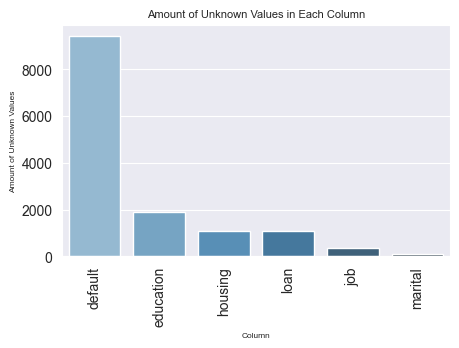

In [3]:
### Visualizing the amount of 'unknown' values in a bar chart

unknowns = df.isin(['unknown']).sum()
unknowns = unknowns[unknowns > 0]
unknowns = unknowns.sort_values(ascending=False)

plt.figure(figsize=(5, 3))
sns.set_style('darkgrid')
sns.barplot(x=unknowns.index, y=unknowns.values, palette='Blues_d')
plt.xticks(rotation=90)
plt.title('Amount of Unknown Values in Each Column', fontsize=8)
plt.xlabel('Column', fontsize=6)
plt.ylabel('Amount of Unknown Values', fontsize=6)
plt.show()

### *Data Cleaning Functions*

In [4]:
### Casting job, martial, education, default, housing, loan, contact, month, day_of_week, poutcome, and y to categorical variables

columns_to_categorize = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']

def cast_as_columns(df):
    for column in columns_to_categorize:
        df[column] = df[column].astype('category')
    return df

### Writing a function that provides ordinal encoding for education, in order of: unknown, illiterate, basic.4y, basic.6y, basic.9y, high.school, professional.course, university.degree

def ordinal_encode_education(df):
    df['education'] = df['education'].cat.reorder_categories(['unknown', 'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree'])
    df['education'] = df['education'].cat.codes
    return df

### Writing a function that drops duration, as it is not known before a call is made

def drop_duration(df):
    df = df.drop('duration', axis=1)
    return df

### Writing a function that encodes the target variable, y, as 0 for no and 1 for yes

def encode_target(df):
    df['y'] = df['y'].cat.codes
    return df

### Writing a function that combines the above functions

def clean_data(df):
    df = cast_as_columns(df)
    df = ordinal_encode_education(df)
    df = drop_duration(df)
    df = encode_target(df)
    return df

### *Data Cleaning and Segmentation*

In [5]:
### Writing a function that has splits the data into a client dataframe, a campaign dataframe, and an external factors dataframe

client_columns = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'y']
campaign_columns = ['contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
external_columns = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']

def split_data(df):
    client_df = df[client_columns]
    campaign_df = df[campaign_columns]
    external_df = df[external_columns]
    return client_df, campaign_df, external_df

### Writing a function that one-hot encodes only the categorical variables in a dataframe, except for 'y'

def one_hot_encode(df):
    df_encoded = df.drop('y', axis=1)
    df_encoded = pd.get_dummies(df_encoded, drop_first=True)
    df_encoded['y'] = df['y']
    df = df_encoded
    return df



In [6]:
### Applying the segmentation function to the data set

client_df, campaign_df, external_df = split_data(clean_data(df))

### One-hot encoding each of the dataframes

client_df = one_hot_encode(client_df)
campaign_df = one_hot_encode(campaign_df)
external_df = one_hot_encode(external_df)

### *Segment: Client data Predictive Power Analysis*

In [7]:
### Performing a train-test split on the client dataframe

X = client_df.drop('y', axis=1)
y = client_df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
y.value_counts()

0    40216
1     5091
Name: y, dtype: int64

Accuracy:  0.8867799602736702
Recall:  0.0
Precision:  0.0
F1 Score:  0.0
ROC AUC Score:  0.5


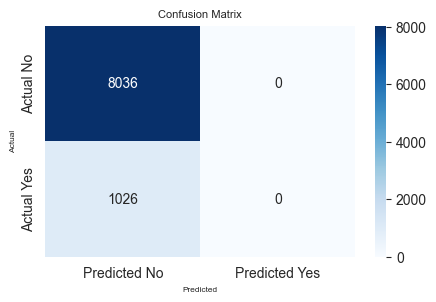

In [9]:
### Fitting and getting the cross-validated accuracy score of a logistic regression model

logreg = LogisticRegressionCV(cv=5, random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)

### Testing the model on the test set and getting the accuracy, recall, precision, and shows the confusion matrix in seaborn

y_pred = logreg.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC Score: ', roc_auc_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns=['Predicted No', 'Predicted Yes'], index=['Actual No', 'Actual Yes'])

plt.figure(figsize=(5, 3))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix', fontsize=8)
plt.xlabel('Predicted', fontsize=6)
plt.ylabel('Actual', fontsize=6)
plt.show()

### *Segment: Campaign data Predictive Power Analysis*

In [10]:
### Performing a train-test split on the campaign dataframe

X = campaign_df.drop('y', axis=1)
y = campaign_df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Accuracy:  0.8974839991171927
Recall:  0.2212475633528265
Precision:  0.6358543417366946
F1 Score:  0.32827187274041936
ROC AUC Score:  0.6025351803822371


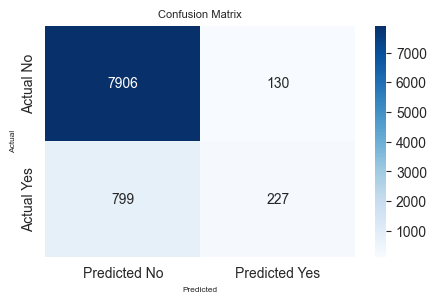

In [11]:
### Fitting and getting the cross-validated accuracy score of a logistic regression model

logreg = LogisticRegressionCV(cv=5, random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)

### Testing the model on the test set and getting the accuracy, recall, precision, and shows the confusion matrix in seaborn

y_pred = logreg.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC Score: ', roc_auc_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns=['Predicted No', 'Predicted Yes'], index=['Actual No', 'Actual Yes'])

plt.figure(figsize=(5, 3))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix', fontsize=8)
plt.xlabel('Predicted', fontsize=6)
plt.ylabel('Actual', fontsize=6)
plt.show()

### *Segment: External data Predictive Power Analysis*

In [12]:
### Performing a train-test split on the external dataframe

X = external_df.drop('y', axis=1)
y = external_df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Accuracy:  0.887111013021408
Recall:  0.03996101364522417
Precision:  0.5189873417721519
F1 Score:  0.07420814479638008
ROC AUC Score:  0.5176161464443144


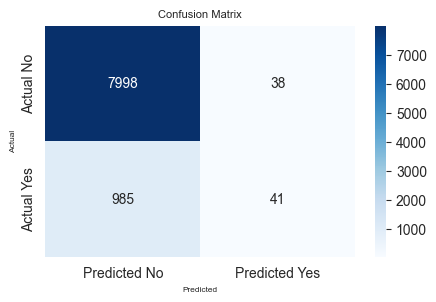

In [13]:
### Fitting and getting the cross-validated accuracy score of a logistic regression model

logreg = LogisticRegressionCV(cv=5, random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)

### Testing the model on the test set and getting the accuracy, recall, precision, and shows the confusion matrix in seaborn

y_pred = logreg.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC Score: ', roc_auc_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns=['Predicted No', 'Predicted Yes'], index=['Actual No', 'Actual Yes'])

plt.figure(figsize=(5, 3))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix', fontsize=8)
plt.xlabel('Predicted', fontsize=6)
plt.ylabel('Actual', fontsize=6)
plt.show()